In [5]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.append(os.getenv("PATH_CUSUM"))
from loguru import logger

import numpy as np
from source.generator.change_point_generator import ChangePointGenerator
from source.model.incremental import RecurrentLeastSquares
from source.detector.cusum import CUSUM_Detector
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Abrupt shift on data

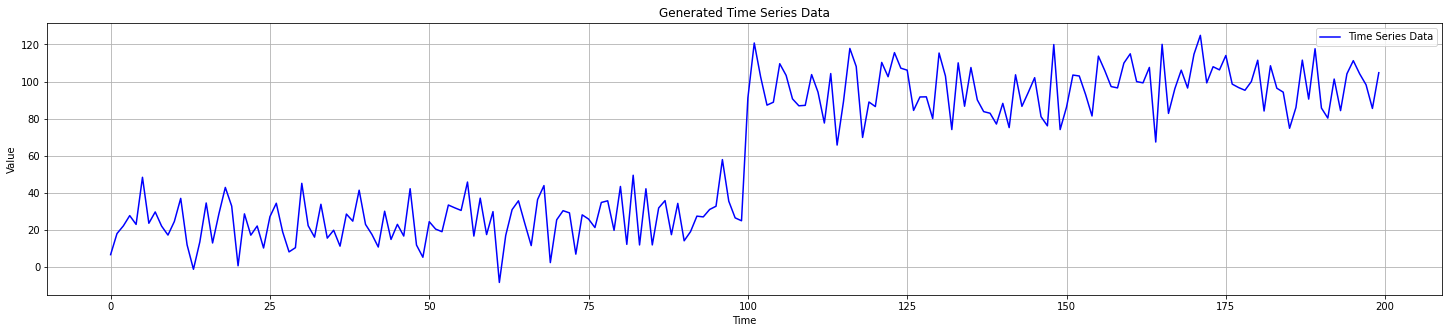

In [6]:
# Set seed
np.random.seed(33)

# Generate time series data with change points
generator = ChangePointGenerator(num_segments=2, segment_length=100, change_point_type='sudden_shift')
generator.generate_data()

# Plot the generated data
generator.plot_data()

# Monitoring ml-model performance on data shift

In [ ]:
# Set number of lags
num_lags = 2

# Initialize model
model = RecurrentLeastSquares(num_variables=num_lags, forgetting_factor=0.99, initial_delta=0.1)

# Detect change points using CUSUM Detector
cusum_detector = CUSUM_Detector(warmup_period=10, delta=1, threshold=5)

# Retrieve observations
observations = np.array(generator.data)

# Store predictions and observed values
list_predictions = []
list_observed = []
list_residuals = []

list_pos_changes = []
list_change_points = []

# Create a figure for the animation with grid layout
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
prediction_ax, residual_ax, change_ax = axs
fig.tight_layout(pad=5.0)

# Animation function
def animate(i):
    if i >= len(observations) - num_lags - 1:
        return

    # Get the input
    X = observations[i:i + num_lags].reshape(-1, 1)

    # Make a prediction
    y_pred = model.predict(X)

    # Wait and get the true value
    logger.info(f" After model prediction the true value is observed {i}")

    # Get the true value
    y = observations[i + num_lags + 1].reshape(-1, 1)

    # Update the model and make a prediction
    model.update(X, y)

    # Store prediction and observed values
    list_predictions.append(y_pred)
    list_observed.append(y[0])

    # Compute residuals
    residuals = np.abs(y - y_pred)
    list_residuals.append(residuals[0])

    # Detect change points
    output_detected = cusum_detector.predict_next(residuals[0])
    list_pos_changes.append(output_detected[0][0])

    # Clear the axes for new plots
    prediction_ax.clear()
    residual_ax.clear()
    change_ax.clear()

    # Plot predictions vs observed values
    prediction_ax.plot(list_observed, label='Obs', color='blue')
    prediction_ax.plot(list_predictions, label='Pred-RLS', color='orange')
    prediction_ax.legend()
    prediction_ax.set_title('Predictions vs Observed')
    
    # Plot residuals
    residual_ax.plot(list_residuals, label='Residuals', color='red')
    residual_ax.legend()
    residual_ax.set_title('Residuals')

    # Plot detected change points
    change_ax.plot(list_pos_changes, label='Performance Cumulative Changes', color='green')
    change_ax.axhline(y=cusum_detector.threshold, color='r', linestyle='--')
    change_ax.legend()
    change_ax.set_title('Detected Change Points')

# Create the animation
ani = FuncAnimation(fig, animate, frames=200, repeat=False)  #len(observations) - num_lags - 1

# Save the animation as a GIF
ani.save('monitoring.gif', writer='pillow', fps=1)

plt.close(fig)  # Prevent the figure from displaying